In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.utils.layer_utils import layer_from_config
from keras.layers import Dense, Dropout, TimeDistributed, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [3]:
adam = Adam(lr = 0.00001)

In [4]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 40
epoch = 0

train_lstm_decay_aucs = np.zeros((folds,n_epochs))
test_lstm_decay_aucs = np.zeros((folds,n_epochs))

train_lstm_aucs = np.zeros((folds,n_epochs))
test_lstm_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_decay = Model(input = sequence, output = output)
    adam = Adam(lr = 0.001)
    lstm_decay.compile(optimizer = adam , loss='mean_squared_error')  

    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm = Model(input = sequence, output = output)
    
    lstm.compile(optimizer = 'adam', loss='mean_squared_error')
    

    
    
    for epoch in range(n_epochs):
        #lstm 
        
        adam = Adam(lr = 0.001*2**(-epoch))
        lstm_decay.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_decay_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_decay.predict(X[train_idx]))
        test_lstm_decay_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_decay.predict(X[test_idx]))
        
        train_lstm_decay_aucs[i][epoch]=train_lstm_decay_auc
        test_lstm_decay_aucs[i][epoch]=test_lstm_decay_auc
        print("LSTM decay: ", train_lstm_decay_auc, test_lstm_decay_auc, epoch)
        
        #lstm 
        lstm.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        
        train_lstm_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm.predict(X[train_idx]))
        test_lstm_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm.predict(X[test_idx]))
        
        train_lstm_aucs[i][epoch]=train_lstm_auc
        test_lstm_aucs[i][epoch]=test_lstm_auc
        print("LSTM: ", train_lstm_auc, test_lstm_auc, epoch)
        
train_lstm_decay_aucs_mean = np.mean(train_lstm_decay_aucs, axis=0)
test_lstm_decay_aucs_mean = np.mean(test_lstm_decay_aucs, axis=0)
train_lstm_aucs_mean=np.mean(train_lstm_aucs, axis=0)
test_lstm_aucs_mean = np.mean(test_lstm_aucs, axis=0)

Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0608    
LSTM decay:  0.867074874036 0.86800132342 0
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0607    
LSTM:  0.867805556548 0.869465646813 0
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0493    
LSTM decay:  0.883888361594 0.889295100402 1
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0492    
LSTM:  0.892615488399 0.89555815959 1
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0457    
LSTM decay:  0.903174551773 0.906971320843 2
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0428    
LSTM:  0.924611726152 0.924586453493 2
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0367    
LSTM decay:  0.936136723763 0.935705323199 3
Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0338    
LSTM:  0.941770524072 0.940112116161 3
Epoch 1/1
6376/6376 [=====================

In [5]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 50
epoch = 0

train_lstm_lr_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1000_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10000_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10000_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1 = Model(input = sequence, output = output)
    adam_lr_1 = Adam(lr = 1)
    lstm_lr_1.compile(optimizer = adam_lr_1 , loss='mean_squared_error')  

    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10 = Model(input = sequence, output = output)
    adam_lr_10 = Adam(lr = 0.1)
    lstm_lr_10.compile(optimizer = adam_lr_10 , loss='mean_squared_error') 
    

    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100 = Model(input = sequence, output = output)
    adam_lr_100 = Adam(lr = 0.01)
    lstm_lr_100.compile(optimizer = adam_lr_100 , loss='mean_squared_error')
    
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000 = Model(input = sequence, output = output)
    adam_lr_1000 = Adam(lr = 0.001)
    lstm_lr_1000.compile(optimizer = adam_lr_1000 , loss='mean_squared_error') 
    
    
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10000 = Model(input = sequence, output = output)
    adam_lr_10000 = Adam(lr = 0.0001)
    lstm_lr_10000.compile(optimizer = adam_lr_10000 , loss='mean_squared_error') 
    
    
    for epoch in range(n_epochs):
        #lstm LR 1
    
        lstm_lr_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1.predict(X[train_idx]))
        test_lstm_lr_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1.predict(X[test_idx]))
        
        train_lstm_lr_1_aucs[i][epoch]=train_lstm_lr_1_auc
        test_lstm_lr_1_aucs[i][epoch]=test_lstm_lr_1_auc
        print("LSTM LR 1: ", train_lstm_lr_1_auc, test_lstm_lr_1_auc, epoch)
        
        #lstm LR 10
    
        lstm_lr_10.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10.predict(X[train_idx]))
        test_lstm_lr_10_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10.predict(X[test_idx]))
        
        train_lstm_lr_10_aucs[i][epoch]=train_lstm_lr_10_auc
        test_lstm_lr_10_aucs[i][epoch]=test_lstm_lr_10_auc
        print("LSTM LR 10: ", train_lstm_lr_10_auc, test_lstm_lr_10_auc, epoch)
        
        
        #lstm LR 100
    
        lstm_lr_100.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100.predict(X[train_idx]))
        test_lstm_lr_100_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100.predict(X[test_idx]))
        
        train_lstm_lr_100_aucs[i][epoch]=train_lstm_lr_100_auc
        test_lstm_lr_100_aucs[i][epoch]=test_lstm_lr_100_auc
        print("LSTM LR 100: ", train_lstm_lr_100_auc, test_lstm_lr_100_auc, epoch)
        
        #lstm LR 1000
    
        lstm_lr_1000.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000.predict(X[train_idx]))
        test_lstm_lr_1000_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000.predict(X[test_idx]))
        
        train_lstm_lr_1000_aucs[i][epoch]=train_lstm_lr_1000_auc
        test_lstm_lr_1000_aucs[i][epoch]=test_lstm_lr_1000_auc
        print("LSTM LR 1000: ", train_lstm_lr_1000_auc, test_lstm_lr_1000_auc, epoch)
        
        
        #lstm LR 1000
    
        lstm_lr_10000.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10000_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10000.predict(X[train_idx]))
        test_lstm_lr_10000_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10000.predict(X[test_idx]))
        
        train_lstm_lr_10000_aucs[i][epoch]=train_lstm_lr_10000_auc
        test_lstm_lr_10000_aucs[i][epoch]=test_lstm_lr_10000_auc
        print("LSTM LR 10000: ", train_lstm_lr_10000_auc, test_lstm_lr_10000_auc, epoch)
        
train_lstm_lr_1_aucs_mean = np.mean(train_lstm_lr_1_aucs, axis=0)
test_lstm_lr_1_aucs_mean = np.mean(test_lstm_lr_1_aucs, axis=0)

train_lstm_lr_10_aucs_mean = np.mean(train_lstm_lr_10_aucs, axis=0)
test_lstm_lr_10_aucs_mean = np.mean(test_lstm_lr_10_aucs, axis=0)

train_lstm_lr_100_aucs_mean = np.mean(train_lstm_lr_100_aucs, axis=0)
test_lstm_lr_100_aucs_mean = np.mean(test_lstm_lr_100_aucs, axis=0)

train_lstm_lr_1000_aucs_mean = np.mean(train_lstm_lr_1000_aucs, axis=0)
test_lstm_lr_1000_aucs_mean = np.mean(test_lstm_lr_1000_aucs, axis=0)


Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0903    
LSTM decay:  0.801347687707 0.806023221416 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0611    
LSTM:  0.872404290702 0.875120482195 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0613    
LSTM decay:  0.83206319314 0.837690384077 1
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0462    
LSTM:  0.900375807183 0.899112540364 1
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0541    
LSTM decay:  0.856950314399 0.862916357596 2
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0384    
LSTM:  0.932737482989 0.935761780605 2
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0517    
LSTM decay:  0.861256292025 0.867187534701 3
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0318    
LSTM:  0.942669585709 0.942635817302 3
Epoch 1/1
6376/6376 [====================

KeyboardInterrupt: 

In [3]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 50
epoch = 0

train_lstm_lr_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1000_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10000_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10000_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1 = Model(input = sequence, output = output)
    adam_lr_1 = Adam(lr = 1)
    lstm_lr_1.compile(optimizer = adam_lr_1 , loss='mean_squared_error')  

    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10 = Model(input = sequence, output = output)
    adam_lr_10 = Adam(lr = 0.1)
    lstm_lr_10.compile(optimizer = adam_lr_10 , loss='mean_squared_error') 
    

    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100 = Model(input = sequence, output = output)
    adam_lr_100 = Adam(lr = 0.01)
    lstm_lr_100.compile(optimizer = adam_lr_100 , loss='mean_squared_error')
    
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000 = Model(input = sequence, output = output)
    adam_lr_1000 = Adam(lr = 0.001)
    lstm_lr_1000.compile(optimizer = adam_lr_1000 , loss='mean_squared_error') 
    
    
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10000 = Model(input = sequence, output = output)
    adam_lr_10000 = Adam(lr = 0.0001)
    lstm_lr_10000.compile(optimizer = adam_lr_10000 , loss='mean_squared_error') 
    
    
    for epoch in range(n_epochs):
        #lstm LR 1
    
        lstm_lr_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1.predict(X[train_idx]))
        test_lstm_lr_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1.predict(X[test_idx]))
        
        train_lstm_lr_1_aucs[i][epoch]=train_lstm_lr_1_auc
        test_lstm_lr_1_aucs[i][epoch]=test_lstm_lr_1_auc
        print("LSTM LR 1: ", train_lstm_lr_1_auc, test_lstm_lr_1_auc, epoch)
        
        #lstm LR 10
    
        lstm_lr_10.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10.predict(X[train_idx]))
        test_lstm_lr_10_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10.predict(X[test_idx]))
        
        train_lstm_lr_10_aucs[i][epoch]=train_lstm_lr_10_auc
        test_lstm_lr_10_aucs[i][epoch]=test_lstm_lr_10_auc
        print("LSTM LR 10: ", train_lstm_lr_10_auc, test_lstm_lr_10_auc, epoch)
        
        
        #lstm LR 100
    
        lstm_lr_100.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100.predict(X[train_idx]))
        test_lstm_lr_100_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100.predict(X[test_idx]))
        
        train_lstm_lr_100_aucs[i][epoch]=train_lstm_lr_100_auc
        test_lstm_lr_100_aucs[i][epoch]=test_lstm_lr_100_auc
        print("LSTM LR 100: ", train_lstm_lr_100_auc, test_lstm_lr_100_auc, epoch)
        
        #lstm LR 1000
    
        lstm_lr_1000.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000.predict(X[train_idx]))
        test_lstm_lr_1000_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000.predict(X[test_idx]))
        
        train_lstm_lr_1000_aucs[i][epoch]=train_lstm_lr_1000_auc
        test_lstm_lr_1000_aucs[i][epoch]=test_lstm_lr_1000_auc
        print("LSTM LR 1000: ", train_lstm_lr_1000_auc, test_lstm_lr_1000_auc, epoch)
        
        
        #lstm LR 1000
    
        lstm_lr_10000.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10000_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10000.predict(X[train_idx]))
        test_lstm_lr_10000_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10000.predict(X[test_idx]))
        
        train_lstm_lr_10000_aucs[i][epoch]=train_lstm_lr_10000_auc
        test_lstm_lr_10000_aucs[i][epoch]=test_lstm_lr_10000_auc
        print("LSTM LR 10000: ", train_lstm_lr_10000_auc, test_lstm_lr_10000_auc, epoch)
        
train_lstm_lr_1_aucs_mean = np.mean(train_lstm_lr_1_aucs, axis=0)
test_lstm_lr_1_aucs_mean = np.mean(test_lstm_lr_1_aucs, axis=0)

train_lstm_lr_10_aucs_mean = np.mean(train_lstm_lr_10_aucs, axis=0)
test_lstm_lr_10_aucs_mean = np.mean(test_lstm_lr_10_aucs, axis=0)

train_lstm_lr_100_aucs_mean = np.mean(train_lstm_lr_100_aucs, axis=0)
test_lstm_lr_100_aucs_mean = np.mean(test_lstm_lr_100_aucs, axis=0)

train_lstm_lr_1000_aucs_mean = np.mean(train_lstm_lr_1000_aucs, axis=0)
test_lstm_lr_1000_aucs_mean = np.mean(test_lstm_lr_1000_aucs, axis=0)


Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.1895    
LSTM LR 1:  0.5 0.5 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.1884    
LSTM LR 10:  0.5 0.5 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0435    
LSTM LR 100:  0.935676336737 0.922898218239 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0603    
LSTM LR 1000:  0.875588499136 0.862159894308 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0938    
LSTM LR 10000:  0.792962091463 0.788596640006 0
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.1884    
LSTM LR 1:  0.5 0.5 1
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.1884    
LSTM LR 10:  0.5 0.5 1
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0303    
LSTM LR 100:  0.948209517761 0.930702795829 1
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0487    
LSTM LR 1000:  0.8902

KeyboardInterrupt: 

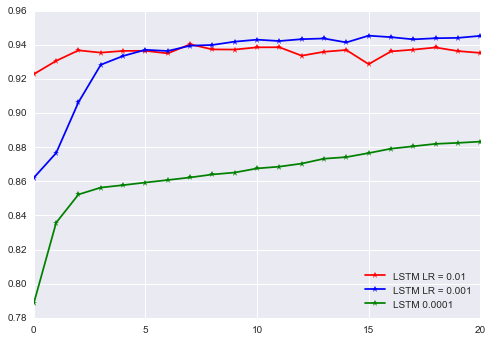

In [5]:
plt.plot(np.arange(0,epoch-1,1), test_lstm_lr_100_aucs[0,0:epoch-1], color= 'r', marker='*', linestyle='-', label ="LSTM LR = 0.01")
plt.plot(np.arange(0,epoch-1,1), test_lstm_lr_1000_aucs[0,0:epoch-1],color='b',marker='*', linestyle='-',label ="LSTM LR = 0.001")
plt.plot(np.arange(0,epoch-1,1), test_lstm_lr_10000_aucs[0,0:epoch-1], color='g',marker='*', linestyle='-', label ="LSTM 0.0001")

plt.legend( loc=4)

In [6]:
from math import exp
math.exp(-2)

0.1353352832366127

In [3]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25

n_epochs = 50
epoch = 0

train_lstm_lr_1_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_10_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_10_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_100_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_100_aucs = np.zeros((folds,n_epochs))

train_lstm_lr_1000_aucs = np.zeros((folds,n_epochs))
test_lstm_lr_1000_aucs = np.zeros((folds,n_epochs))

for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
 
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1 = Model(input = sequence, output = output)
    adam_lr_1 = Adam(lr = 0.01)
    lstm_lr_1.compile(optimizer = adam_lr_1 , loss='mean_squared_error')
    
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_10 = Model(input = sequence, output = output)
    adam_lr_10 = Adam(lr = 0.01)
    lstm_lr_10.compile(optimizer = adam_lr_10 , loss='mean_squared_error')
    
    
    

    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_100 = Model(input = sequence, output = output)
    adam_lr_100 = Adam(lr = 0.01)
    lstm_lr_100.compile(optimizer = adam_lr_100 , loss='mean_squared_error')
    
    
    
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, mask_zero = True)(sequence)
    forwards = LSTM(hidden)(embedded)
    backwards = LSTM(hidden, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm_lr_1000 = Model(input = sequence, output = output)
    adam_lr_1000 = Adam(lr = 0.001)
    lstm_lr_1000.compile(optimizer = adam_lr_1000 , loss='mean_squared_error')
    

    
    
    for epoch in range(n_epochs):
        
        

        adam_lr_1.lr.set_value(0.01*math.exp(-math.sqrt(epoch)))
        lstm_lr_1.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1.predict(X[train_idx]))
        test_lstm_lr_1_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1.predict(X[test_idx]))
        
        train_lstm_lr_1_aucs[i][epoch]=train_lstm_lr_1_auc
        test_lstm_lr_1_aucs[i][epoch]=test_lstm_lr_1_auc
        print("LSTM LR = 0.01*exp(-sqrt(epoch)) ", train_lstm_lr_1_auc, test_lstm_lr_1_auc, epoch)
        print("current learning rate: ", adam_lr_1.lr.get_value() )
        
        
        
        
        
        
        adam_lr_10.lr.set_value(0.01*math.exp(-epoch))
        lstm_lr_10.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_10_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_10.predict(X[train_idx]))
        test_lstm_lr_10_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_10.predict(X[test_idx]))
        
        train_lstm_lr_10_aucs[i][epoch]=train_lstm_lr_10_auc
        test_lstm_lr_10_aucs[i][epoch]=test_lstm_lr_10_auc
        print("LSTM exp(-epoch): ", train_lstm_lr_10_auc, test_lstm_lr_10_auc, epoch)
        print("current learning rate: ", adam_lr_10.lr.get_value() )     

        
        
        
        
        adam_lr_100.lr.set_value(0.01*math.exp(-epoch**2))
        lstm_lr_100.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_100_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_100.predict(X[train_idx]))
        test_lstm_lr_100_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_100.predict(X[test_idx]))
        
        train_lstm_lr_100_aucs[i][epoch]=train_lstm_lr_100_auc
        test_lstm_lr_100_aucs[i][epoch]=test_lstm_lr_100_auc
        print("LSTM exp(-epoch^2): ", train_lstm_lr_100_auc, test_lstm_lr_100_auc, epoch)
        print("current learning rate: ", adam_lr_100.lr.get_value() )
        
        
        
        
        
        lstm_lr_1000.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    

        train_lstm_lr_1000_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm_lr_1000.predict(X[train_idx]))
        test_lstm_lr_1000_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm_lr_1000.predict(X[test_idx]))
        
        train_lstm_lr_1000_aucs[i][epoch]=train_lstm_lr_1000_auc
        test_lstm_lr_1000_aucs[i][epoch]=test_lstm_lr_1000_auc
        print("LSTM LR Default: ", train_lstm_lr_1000_auc, test_lstm_lr_1000_auc, epoch)
        print("current learning rate: ", adam_lr_1000.lr.get_value() )

        


train_lstm_lr_100_aucs_mean = np.mean(train_lstm_lr_100_aucs, axis=0)
test_lstm_lr_100_aucs_mean = np.mean(test_lstm_lr_100_aucs, axis=0)



Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0450    
LSTM LR = 0.01*exp(-sqrt(epoch))  0.933336321337 0.932807638996 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0443    
LSTM exp(-epoch):  0.937982929159 0.936198103452 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0437    
LSTM exp(-epoch^2):  0.937638094811 0.934761391389 0
current learning rate:  0.009999999776482582
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0622    
LSTM LR Default:  0.865236271755 0.866142879145 0
current learning rate:  0.0010000000474974513
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0293    
LSTM LR = 0.01*exp(-sqrt(epoch))  0.951004277515 0.947706321093 1
current learning rate:  0.0036787944845855236
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0284    
LSTM exp(-epoch):  

In [4]:
train_lstm_lr_1_aucs_mean = np.mean(train_lstm_lr_1_aucs, axis=0)
test_lstm_lr_1_aucs_mean = np.mean(test_lstm_lr_1_aucs, axis=0)

train_lstm_lr_10_aucs_mean = np.mean(train_lstm_lr_10_aucs, axis=0)
test_lstm_lr_10_aucs_mean = np.mean(test_lstm_lr_10_aucs, axis=0)

train_lstm_lr_100_aucs_mean = np.mean(train_lstm_lr_100_aucs, axis=0)
test_lstm_lr_100_aucs_mean = np.mean(test_lstm_lr_100_aucs, axis=0)

train_lstm_lr_1000_aucs_mean = np.mean(train_lstm_lr_1000_aucs, axis=0)
test_lstm_lr_1000_aucs_mean = np.mean(test_lstm_lr_1000_aucs, axis=0)

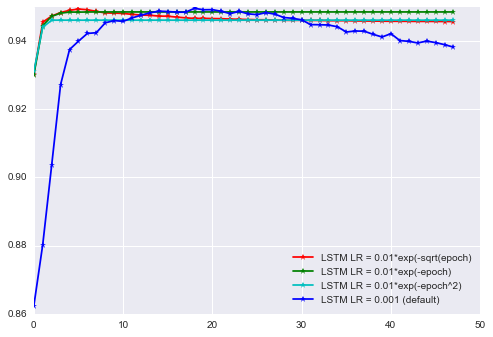

In [15]:
plt.plot(np.arange(0,epoch-1,1), test_lstm_lr_1_aucs_mean[0:epoch-1], color= 'r', marker='*', linestyle='-', label ="LSTM LR = 0.01*exp(-sqrt(epoch)")
plt.plot(np.arange(0,epoch-1,1), test_lstm_lr_10_aucs_mean[0:epoch-1], color= 'g', marker='*', linestyle='-', label ="LSTM LR = 0.01*exp(-epoch)")
plt.plot(np.arange(0,epoch-1,1), test_lstm_lr_100_aucs_mean[0:epoch-1], color= 'c', marker='*', linestyle='-', label ="LSTM LR = 0.01*exp(-epoch^2)")
plt.plot(np.arange(0,epoch-1,1), test_lstm_lr_1000_aucs_mean[0:epoch-1], color= 'b', marker='*', linestyle='-', label ="LSTM LR = 0.001 (default)")

plt.legend( loc=4)
plt.Figure(figsize=(100,100),dpi = 130)

AttributeError: 'Model' object has no attribute 'lr'